In [1]:
import numpy as np
import glob
from os.path import basename
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import wilcoxon, ttest_ind, ttest_rel
import h5py
import logomaker

# Helper functions 

In [2]:
def parse_rmse_plotdf(ensemble_rmse, distilled_rmse):
    '''
    given lists of attribution rmse for ensemble of models and distilled models
    parse a df for plotting
    '''

    # load all euclidean distances for individual models
    ensemble_rmse_arr = np.transpose(np.stack([np.load(f) for f in ensemble_rmse]))

    # load all distances for distilled models
    distilled_rmse_arr = np.transpose(np.stack([np.load(f) for f in distilled_rmse]))
    
    ensemble_rmse_df = pd.DataFrame(ensemble_rmse_arr)
    ensemble_rmse_df['model'] = 'original'
    distilled_rmse_df = pd.DataFrame(distilled_rmse_arr)
    distilled_rmse_df['model'] = 'distilled'

    # combine 
    all_dist_df = pd.concat([ensemble_rmse_df, distilled_rmse_df])
    # melt
    plotdf = all_dist_df.melt(id_vars='model', var_name='model_ix', value_name='rmse')

    # wilcox test
    ensemble_dist_flat = ensemble_rmse_arr.flatten()
    distilled_dist_flat = distilled_rmse_arr.flatten()
    res = wilcoxon(ensemble_dist_flat, distilled_dist_flat)
    return plotdf, res

def get_variance_plotdf(method, celltype):
    ensemble_std = np.load(f"../results/lentiMPRA/{celltype}/top1000_{celltype}_{method}_stdev.npy")
    distilled_std = np.load(f"../results/distilled_lentiMPRA_epistemic/{celltype}/top1000_{celltype}_{method}_stdev.npy")
    stdev_df = pd.DataFrame(data=np.hstack((np.expand_dims(ensemble_std, axis=1), np.expand_dims(distilled_std, axis=1))), columns=['original', 'distilled'])
    stdev_plotdf = pd.melt(stdev_df, var_name='model', value_name='stdev')
    stdev_wilcox = wilcoxon(ensemble_std, distilled_std)
    return stdev_plotdf, stdev_wilcox

def get_rmse_plotdf(method, celltype):
    ensemble_rmse = glob.glob(f"../results/lentiMPRA/{celltype}/*_top1000_{celltype}_{method}_euclidean_dist.npy")
    distilled_rmse = glob.glob(f"../results/distilled_lentiMPRA_epistemic/{celltype}/*_top1000_{celltype}_{method}_euclidean_dist.npy")
    rmse_plotdf, rmse_wilcox = parse_rmse_plotdf(ensemble_rmse, distilled_rmse)
    return rmse_plotdf, rmse_wilcox

# K562

## Saliency

### RMSE

In [3]:
method = 'saliency'
celltype = 'K562'
k562_saliency_rmse_plotdf, k562_saliency_rmse_wilcox = get_rmse_plotdf(method, celltype)

In [4]:
# parse rmse results for boxplot version
k562_saliency_rmse_boxplot_df = k562_saliency_rmse_plotdf.groupby(['model','model_ix'])['rmse'].mean().reset_index()

k562_saliency_rmse_boxplot_df.to_csv('fig1j_plot_data.csv', index=False)

In [5]:
# t-test 
_, k562_rmse_p = ttest_ind(k562_saliency_rmse_boxplot_df[k562_saliency_rmse_boxplot_df['model']=='original']['rmse'].values, k562_saliency_rmse_boxplot_df[k562_saliency_rmse_boxplot_df['model']=='distilled']['rmse'].values)

### Variability

In [6]:
# get plotdf 
k562_saliency_var_plotdf, k562_saliency_var_wilcox = get_variance_plotdf(method, celltype)
# k562_saliency_var_wilcox
k562_saliency_var_plotdf.to_csv('fig1k_plot_data.csv', index=False)


In [7]:
# calculate t-test for variability
_, k562_var_p = ttest_rel(k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='original']['stdev'].values,
                     k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='distilled']['stdev'].values)

### Plot

# HepG2
## Saliency
### RMSE

In [9]:
method = 'saliency'
celltype = 'HepG2'
hepg2_saliency_rmse_plotdf, hepg2_saliency_rmse_wilcox = get_rmse_plotdf(method, celltype)

# parse rmse results for boxplot version
hepg2_saliency_rmse_plotdf = hepg2_saliency_rmse_plotdf.groupby(['model','model_ix'])['rmse'].mean().reset_index()

In [10]:
# t-test 
_, hepg2_rmse_p = ttest_ind(hepg2_saliency_rmse_plotdf[hepg2_saliency_rmse_plotdf['model']=='original']['rmse'].values, hepg2_saliency_rmse_plotdf[hepg2_saliency_rmse_plotdf['model']=='distilled']['rmse'].values)

### Variability

In [11]:
hepg2_saliency_var_plotdf, hepg2_saliency_var_wilcox = get_variance_plotdf(method, celltype)

In [12]:
# calculate t-test for variability
_, hepg2_var_p = ttest_rel(hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='original']['stdev'].values,
                          hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='distilled']['stdev'].values)

### Plot

# Plot similarity

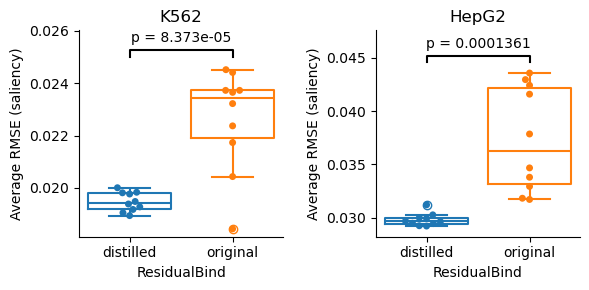

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

# plot k562
sns.boxplot(data=k562_saliency_rmse_boxplot_df, x='model', y='rmse', hue='model', ax=axs[0], fill=False)
sns.swarmplot(data=k562_saliency_rmse_boxplot_df, x='model', y='rmse', hue='model', ax=axs[0], dodge=False, legend=False)
axs[0].set_ylim(k562_saliency_rmse_boxplot_df['rmse'].min()-0.0003, k562_saliency_rmse_boxplot_df['rmse'].max()+0.0015)
axs[0].set_title('K562')

    
# add p-value label
x1, x2 = 0, 1
y, h = axs[0].get_ylim()[1]-0.001, (axs[0].get_ylim()[1] - axs[0].get_ylim()[0]) * 0.03
axs[0].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
axs[0].text((x1+x2)*.5, y+h+0.0002, f"p = {k562_rmse_p:.4g}", ha='center', va='bottom')

# plot hepg2
sns.boxplot(data=hepg2_saliency_rmse_plotdf, x='model', y='rmse', hue='model', ax=axs[1], fill=False)
sns.swarmplot(data=hepg2_saliency_rmse_plotdf, x='model', y='rmse', hue='model', ax=axs[1], dodge=False, legend=False)
axs[1].set_ylim([hepg2_saliency_rmse_plotdf['rmse'].min()-0.001, hepg2_saliency_rmse_plotdf['rmse'].max()+0.004])
axs[1].set_title('HepG2')

# add p-value label
x1, x2 = 0, 1
y, h = axs[1].get_ylim()[1]-0.003, (axs[1].get_ylim()[1] - axs[1].get_ylim()[0]) * 0.03
axs[1].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
axs[1].text((x1+x2)*.5, y+h+0.0005, f"p = {hepg2_rmse_p:.4g}", ha='center', va='bottom')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Average RMSE (saliency)')
    ax.set_xlabel('ResidualBind')

fig.tight_layout()
fig.show()
fig.savefig("ResidualBind_similarity.pdf")

# Plot variability

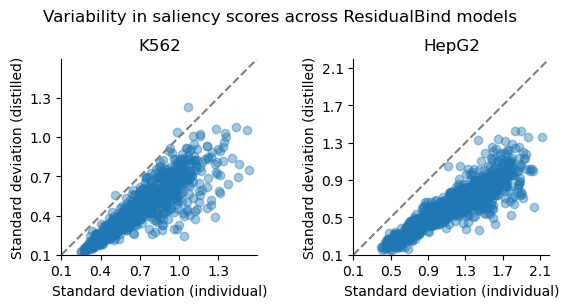

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(6,3))

# plot k562
axs[0].scatter(x=k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='original']['stdev'].values,
               y=k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='distilled']['stdev'].values, alpha=0.4)
axs[0].set_title("K562")
axs[0].set_aspect('equal')

# # Determine the min and max range
min_range = np.floor(min(np.min(k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='original']['stdev'].values),
                         np.min(k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='distilled']['stdev'].values))*10)/10
max_range = np.ceil(max(np.max(k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='original']['stdev'].values), 
                      np.max(k562_saliency_var_plotdf[k562_saliency_var_plotdf['model']=='distilled']['stdev'].values))*10)/10
# Set x and y limits to be the same
axs[0].set_xlim(min_range, max_range)
axs[0].set_ylim(min_range, max_range)

# Set the same ticks for both axes
ticks = np.arange(min_range, max_range, 0.3)  # +0.1 to include the upper limit
axs[0].set_xticks(ticks)
axs[0].set_yticks(ticks)

# add identity line
axs[0].plot([min_range, max_range], [min_range, max_range], color='grey', linestyle='--')

# plot hepg2
axs[1].scatter(x=hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='original']['stdev'].values,
               y=hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='distilled']['stdev'].values, alpha=0.4)
axs[1].set_title("HepG2")
axs[1].set_aspect('equal')

# # Determine the min and max range
min_range = np.floor(min(np.min(hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='original']['stdev'].values),
                         np.min(hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='distilled']['stdev'].values))*10)/10
max_range = np.ceil(max(np.max(hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='original']['stdev'].values), 
                      np.max(hepg2_saliency_var_plotdf[hepg2_saliency_var_plotdf['model']=='distilled']['stdev'].values))*10)/10

# Set x and y limits to be the same
axs[1].set_xlim(min_range, max_range)
axs[1].set_ylim(min_range, max_range)

# Set the same ticks for both axes
ticks = np.arange(min_range, max_range, 0.4)  # +0.1 to include the upper limit
axs[1].set_xticks(ticks)
axs[1].set_yticks(ticks)

# add identity line
axs[1].plot([min_range, max_range], [min_range, max_range], color='grey', linestyle='--')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Standard deviation (individual)')
    ax.set_ylabel('Standard deviation (distilled)')

fig.suptitle('Variability in saliency scores across ResidualBind models')
fig.tight_layout()
fig.show()
fig.savefig("ResidualBind_attribution_variability.png", dpi=300)